# HW08

## Exercises to practice pandas, data analysis, regression and classification

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [2]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

from os import listdir, path
from sklearn.preprocessing import OrdinalEncoder

from data_utils import object_from_json_url
from data_utils import StandardScaler
from data_utils import LFWUtils
from data_utils import LinearRegression, RandomForestClassifier, SVC
from data_utils import classification_error, display_confusion_matrix, regression_error
from data_utils import PolynomialFeatures

from image_utils import make_image, open_image

from HW08_utils import CamUtils

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/DM-GY-9103-2024F-H/WK02).

This is the dataset that has anthropometric information about U.S. Army personnel.

In [4]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

#### Nested data

This is that *nested* dataset from Week 02.

# 🤔

Let's load it into a `DataFrame` to see what happens.

In [5]:
# Read into DataFrame
ansur_df = pd.DataFrame.from_records(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear,foot,hand,head
0,18,F,66,135,1699,1645,"{'breadth': 30, 'length': 61, 'protrusion': 20}","{'breadth': 97, 'length': 243}","{'breadth': 78, 'length': 182, 'palm': 108}","{'height': 243, 'circumference': 557}"
1,30,M,68,207,1749,1715,"{'breadth': 35, 'length': 63, 'protrusion': 17}","{'breadth': 100, 'length': 252}","{'breadth': 87, 'length': 184, 'palm': 114}","{'height': 238, 'circumference': 560}"
2,27,M,67,121,1684,1657,"{'breadth': 36, 'length': 59, 'protrusion': 24}","{'breadth': 92, 'length': 251}","{'breadth': 84, 'length': 180, 'palm': 103}","{'height': 239, 'circumference': 516}"
3,20,M,73,185,1878,1828,"{'breadth': 36, 'length': 60, 'protrusion': 21}","{'breadth': 104, 'length': 280}","{'breadth': 95, 'length': 201, 'palm': 124}","{'height': 270, 'circumference': 582}"
4,33,M,76,150,1977,1883,"{'breadth': 39, 'length': 65, 'protrusion': 27}","{'breadth': 101, 'length': 271}","{'breadth': 90, 'length': 194, 'palm': 113}","{'height': 254, 'circumference': 559}"



# 😓🙄

That didn't work too well. We ended up with objects in our columns.

Luckily, our `DataFrame` library has a function called [`json_normalize()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) that can help.

In [6]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()
print(ansur_df.columns)


Index(['age', 'gender', 'height', 'weight', 'span', 'stature', 'ear.breadth',
       'ear.length', 'ear.protrusion', 'foot.breadth', 'foot.length',
       'hand.breadth', 'hand.length', 'hand.palm', 'head.height',
       'head.circumference'],
      dtype='object')


Much better. `DataFrames` are magic.

#### Data Exploration

Before we start creating models, let's do a little bit of data analysis and get a feeling for the shapes, distributions and relationships of our data.

1. Print `min`, `max` and `average` values for all of the features.
2. Print `covariance` tables for `age`, `ear.length` and `head.circumference`.
3. Plot `age`, `ear.length` and `head.circumference` versus the $1$ *feature* that is most correlated to each of them.

Don't forget to *encode* and *normalize* the data.

[[0.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
age
	min: 17
	max: 58
	mean: 29.74535714285714
	std: 8.660974579836212
gender
	min: 0.0
	max: 1.0
	mean: 0.6726785714285715
	std: 0.46927756842390905
height
	min: 56
	max: 94
	mean: 68.24732142857142
	std: 3.869787625164158
weight
	min: 0
	max: 321
	mean: 174.55839285714285
	std: 33.74724269669339
span
	min: 1323
	max: 2121
	mean: 1763.703392857143
	std: 110.97415851014334
stature
	min: 1409
	max: 1993
	mean: 1714.265357142857
	std: 90.10060032052252
ear.breadth
	min: 25
	max: 46
	mean: 35.128928571428574
	std: 3.2152885799189583
ear.length
	min: 46
	max: 81
	mean: 62.637142857142855
	std: 4.826932876481199
ear.protrusion
	min: 13
	max: 34
	mean: 22.266785714285714
	std: 3.16378592388673
foot.breadth
	min: 77
	max: 126
	mean: 98.85089285714285
	std: 6.645711036489393
foot.length
	min: 198
	max: 323
	mean: 262.9919642857143
	std: 17.40890427103313
hand.breadth
	min: 67
	max: 105
	mean: 84.93696428571428
	std: 6.35468233414803
hand.length
	min: 1

age                   1.000179
gender                0.062201
height                0.029467
weight                0.217017
span                  0.064304
stature               0.037972
ear.breadth           0.187740
ear.length            0.292098
ear.protrusion       -0.009254
foot.breadth          0.064993
foot.length           0.048699
hand.breadth          0.133830
hand.length           0.104642
hand.palm             0.120726
head.height           0.038637
head.circumference    0.014044
Name: age, dtype: float64

age                   0.292098
gender                0.463540
height                0.421910
weight                0.487481
span                  0.401564
stature               0.438604
ear.breadth           0.454968
ear.length            1.000179
ear.protrusion        0.382646
foot.breadth          0.436241
foot.length           0.419030
hand.breadth          0.465829
hand.length           0.335176
hand.palm             0.341726
head.height           0.384718
head.circumference    0.283878
Name: ear.length, dtype: float64

age                   0.014044
gender                0.339537
height                0.439234
weight                0.540160
span                  0.476903
stature               0.462999
ear.breadth           0.221058
ear.length            0.283878
ear.protrusion        0.124790
foot.breadth          0.492590
foot.length           0.501324
hand.breadth          0.466310
hand.length           0.464342
hand.palm             0.451345
head.height           0.546534
head.circumference    1.000179
Name: head.circumference, dtype: float64

Index(['age', 'gender', 'height', 'weight', 'span', 'stature', 'ear.breadth',
       'ear.length', 'ear.protrusion', 'foot.breadth', 'foot.length',
       'hand.breadth', 'hand.length', 'hand.palm', 'head.height',
       'head.circumference'],
      dtype='object')


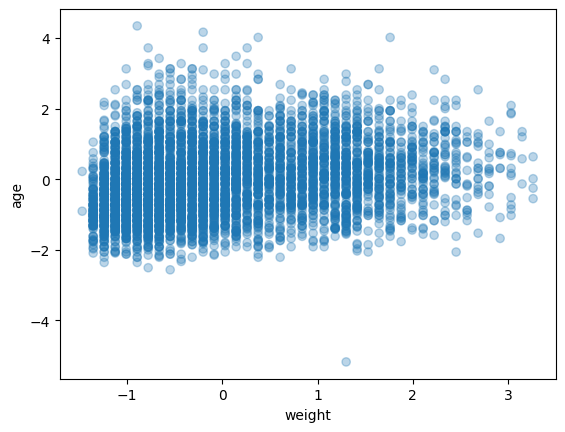

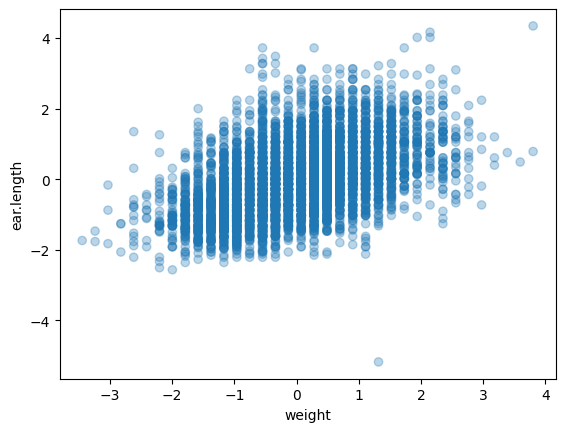

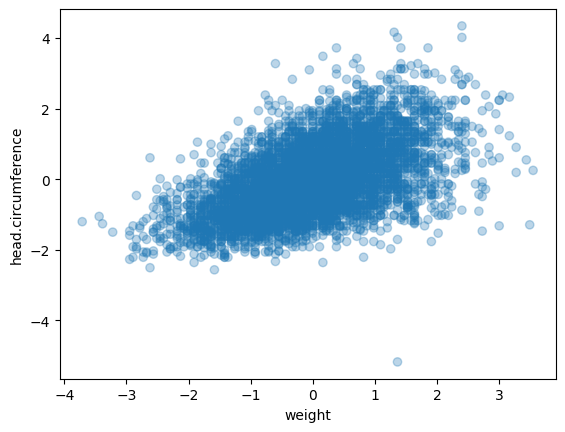

In [7]:
# Work on Data Exploration here

# Define the order for encoding gender
gender_order = ['F', 'M']

# # Initialize the encoder with the specified categories
ansur_encoder = OrdinalEncoder(categories=[gender_order])

# # Fit and transform the gender column
gender_val = ansur_encoder.fit_transform(ansur_df[["gender"]].values)

# # Replace the original gender column with the encoded values
ansur_df["gender"] = gender_val

# Print the encoded values for verification
print(gender_val)

## 1. Print min, max, avg
ansur_df.head()
for f in ansur_df:
    print(f)
    print("\tmin:", ansur_df[f].min())
    print("\tmax:", ansur_df[f].max())
    print("\tmean:", ansur_df[f].mean())
    print("\tstd:", ansur_df[f].std())


# ### Normalize all data

ansur_scaler = StandardScaler()
# ansur_scaled = ansur_scaler.fit_transform(a_numerical_df)
ansur_scaled = ansur_scaler.fit_transform(ansur_df)

## 2. Print Covariances
display(ansur_scaled.cov()["age"])
display(ansur_scaled.cov()["ear.length"])
display(ansur_scaled.cov()["head.circumference"])

## 3. Plot features most correlated to age, ear length and head circumference
features = ["age", "ear.length", "head.circumference"]
print(ansur_scaled.columns)

for f in features:
    plt.scatter(ansur_scaled[f], ansur_scaled["weight"], marker='o', linestyle='', alpha=0.3)
    plt.xlabel("weight")
    plt.ylabel(f)
    plt.show()

### Interpretation

<span style="color:hotpink;">
Does anything stand out about these graphs? Or the correlations?<br>
Are correlations symmetric? Does the feature most correlated to ear length also have ear length as its most correlated pair?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

In my analysis, I see that weight vs head.circumference and ear.length are very similar after plotting the data. It suggests that as the weight increases that the ear length and head circumference increases proportionally. 

### Regression

Now, we want to create a regression model to predict `head.circumference` from the data.

From our [Week 08](https://github.com/DM-GY-9103-2024F-H/WK08) notebook, we can create a regression model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (done! ⚡️)
3. Normalize the data (done! 🍾)
4. Separate the outcome variable and the input features
5. Create a regression model using all features
6. Run model on training data and measure error
7. Plot predictions and interpret results
8. Run model on test data, measure error, plot predictions, interpret results

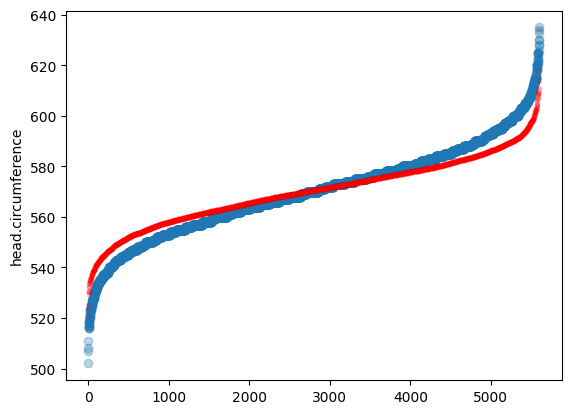

In [8]:
# Work on Regression Model here

## Separate outcome variable and input features
h_circumference = ansur_scaled["head.circumference"]
features = ansur_scaled.drop(columns=["head.circumference"])
poly = PolynomialFeatures(degree=3, include_bias=False)
features_poly = poly.fit_transform(features)


## Create a regression model
headC_model = LinearRegression()
model = headC_model.fit(features_poly, h_circumference)
## run model 
predicted_scaled = headC_model.predict(features_poly)
## un-normalize data
predicted =ansur_scaler.inverse_transform(predicted_scaled)

## Measure error on training data
regression_error(ansur_df["head.circumference"], predicted["head.circumference"])
## Plot predictions and interpret results
a_original = sorted(ansur_df["head.circumference"])
a_predicted = sorted(predicted["head.circumference"])

# Plot the original and predicted prices
plt.plot(a_original, marker='o', linestyle='', alpha=0.3)
plt.plot(a_predicted, color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
plt.ylabel("head.circumference")
plt.show()

In [9]:
## Load Test Data
ANSUR_TEST_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/ansur-test.json"
ansur_test_data = object_from_json_url(ANSUR_TEST_FILE)
ansur_test_df = pd.json_normalize(ansur_test_data)


gender_order = [['F', 'M']]
ansur_encoder = OrdinalEncoder(categories=gender_order)
gender_val = ansur_encoder.fit_transform(ansur_test_df[['gender']].values)

ansur_test_df['gender_encoded'] = gender_val

a_numerical_df = ansur_test_df.drop(columns=["gender"])

print(a_numerical_df.head())


   age  height  weight  span  stature  ear.breadth  ear.length  \
0   20      70     150  1750     1738           36          65   
1   39      63     137  1654     1583           32          62   
2   23      67     150  1799     1725           40          63   
3   32      69     180  1803     1730           31          65   
4   20      74     170  1887     1822           37          67   

   ear.protrusion  foot.breadth  foot.length  hand.breadth  hand.length  \
0              20            99          262            87          195   
1              17            92          249            78          186   
2              20            96          275            90          202   
3              24           102          265            87          192   
4              31           105          277            84          198   

   hand.palm  head.height  head.circumference  gender_encoded  
0        113          255                 555             1.0  
1        112          24

In [10]:
## Load Test Data
ANSUR_TEST_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/ansur-test.json"
ansur_test_data = object_from_json_url(ANSUR_TEST_FILE)
ansur_test_df = pd.json_normalize(ansur_test_data)

ansur_test_encoded_df = ansur_test_df.copy()

g_vals = ansur_encoder.transform(ansur_test_df[["gender"]].values)
ansur_test_encoded_df[["gender"]] = g_vals

ansur_test_scaled_df = ansur_scaler.transform(ansur_test_encoded_df)


In [13]:
## Run model on test data
predicted_scaled = headC_model.predict(features_poly)

## Measure error on test data
predicted =ansur_scaler.inverse_transform(predicted_scaled)
regression_error(ansur_test_scaled_df["head.circumference"], predicted["head.circumference"])
## Plot predictions and interpret results
a_original = sorted(ansur_test_scaled_df["head.circumference"])
a_predicted = sorted(predicted["head.circumference"])

## Plot predictions and interpret results
plt.plot(a_original, marker='o', linestyle='', alpha=0.3)
plt.plot(a_predicted, color='r', marker='o', markersize='3', linestyle='', alpha=0.1)
plt.ylabel("head.circumference")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [468, 5600]

### Interpretation

<span style="color:hotpink;">
How well does your classifier perform?<br>
How could you improve it?<br>
Are there ranges of circumferences that don't get predicted well?
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>

## Classification

The dataset we are going to use has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

### Loading Data

If we look at the images in `./data/images/0801-500/train/`, we'll notice that they are named and organized in a very particular way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

In [ ]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/images/0801-500/train") if f.endswith(".jpg")]



In [ ]:
# TODO: check and see what is inside the list here
print(train_files[:4])


Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [ ]:
pixel_data = []
label_data = []

for fname in train_files:
  label = CamUtils.get_label(fname)
  img = open_image(path.join("./data/images/0801-500/train", fname))
  pixel_data.append(img.pixels)
  label_data.append(label)

In [ ]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list
for fname, label in zip(train_files[:5], label_data[:5]):
    print(f"Filename: {fname}, Extracted Label: {label}")
print(label_data[:4])
print(train_files[:4])


The labels and the filenames won't match exactly since labels start at $0$ and the filenames skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly:

In [12]:
display(make_image(pixel_data[0], width=256))
display(make_image(pixel_data[10], width=256))

NameError: name 'pixel_data' is not defined

And now might not be a bad time to peek into the `data/images/0801-500/` directories to see what's inside them and what the images look like.... and get to know the data...

### DataFrame it

Let's put our raw pixel data into a `DataFrame`, and create a column for storing each image's label.

(this next cell might take a while to run)

In [ ]:
train_df = pd.DataFrame(pixel_data)
train_df["label"] = label_data

Let's inspect our `DataFrame`:

In [ ]:
train_df.head()

NameError: name 'train_df' is not defined

### Test Files

If that worked, repeat the process for the test files inside the `./data/images/0801-500/test/` directory.

We can almost use the exact same steps as we did above to create a `DataFrame`, the only difference being that we don't have labels for these images.

In [ ]:
# TODO: create a list of files in the test/ directory
test_files = [f for f in listdir("./data/images/0801-500/test") if f.endswith(".jpg")]

# TODO: check its length and content
test_pixel_data = []

# TODO: loop over files and load their pixels into a list
for fname in test_files:
    img = open_image(f"./data/images/0801-500/test/{fname}")
    test_pixel_data.append(img.pixels)

# TODO: load into DataFrame (this might take 20 - 30 seconds)


: 

Check the `DataFrame`

In [ ]:
test_df.head()

Looks like data!!

We could train a `RandomForestClassifier` directly on this `DataFrame` and see what would happen, but my guess is that Python runs out of memory and crashes our tab/browser/computer...

We'll use _projection_ to reduce the number of dimensions in our dataset. Projection is when we just drop some of the columns in our dataset. 

Which columns ? That's up to us.

Let's first try using the first $N$ columns/features where $N$ is a number around $10$.

This is how we get the first $N$ columns from a `DataFrame`:

In [ ]:
# split input and output features
NUM_FEATURES = 10
chosen_columns = train_df.columns[:NUM_FEATURES]
train_features = train_df[chosen_columns]

out_features = train_df["label"]

# also separate test dataset features
test_features = test_df[chosen_columns]

From our [Week 08](https://github.com/DM-GY-9103-2024F-H/WK08) notebook, we can create a classification model by following these steps:

1. Load dataset (done! 🎉)
2. Encode label features as numbers (not needed! done! ⚡️)
3. Normalize the data (not needed! done! 🍾)
4. Separate the outcome variable and the input features (done! ☀️)
5. Create a model using chosen features
6. Run model on training data and measure error
7. Run model on test data, measure error, plot predictions, interpret results

In [ ]:
# TODO: create a brand new classifier
# TODO: fit the model
# TODO: run predictions
# TODO: measure classification accuracy

That should look promising. Let's run this on our test dataset.

Remember we already separated the test data features into a variable called `test_features` above.

Now we just have to run the prediction and measure accuracy.

In [ ]:
# TODO: run predictions on test data
# TODO: measure classification accuracy

### Interpretation

Using just the first $10$ pixels of the image the classifier is able to label most of the images correctly.

<span style="color:hotpink">
How can we improve this classifier? How does the number of features affect the classification accuracy of the test data<br>
How does the choice of pixels affect the accuracy?<br><br>
Experiment with some of these parameters and explain your findings below.
</span>

<span style="color:hotpink;">EDIT THIS CELL WITH ANSWER</span>